# PID 

## Simple Mobile Robot

Simple 1D mobile robot (or vehicle)
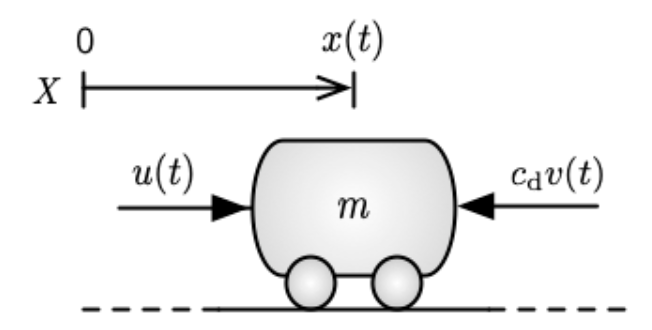

Model as follow: Let $v(t) \text[m/s]$ be the speed of a mobile robot that travels in a straight line and suppose that it has mass $m>0 \text[kg]$, a drag coefficient $c_d > 0 \text[kg/s]$, and that its wheels generate a force $u(t) \in \mathbb{R} \text[N]$ that we get to choose. Applying Newton's Second Law:

$$u(t) - c_d v(t) = m \dot{v}(t)$$

Note that the model is conveniently linear (i.e., obeys the _superposition principle_). This is important because the PID control structure assumes that the system you are trying to control can be (locally) approximated by a linear model. Now simulate the ideal robot's response to inputs $u(t)$.

In [1]:
import numpy as np
import matplotlib.pyplot as plt

SIM_TIME = 10.0 # simulation time
T = 0.1 # sample period
MASS = 1.5  # mobile robot's mass
C_DRAG = 2.0 # drag coefficient

t = np.arange(0, SIM_TIME, T)  # array of simulation time t
N = np.size(t) # total number of simulation data points

Write a function to model the mobile robot's speed as v [m/s] as a function of the force input u as u [N], where $u_k = u (kT)$, $k=0,1,2, \dots$ is applied as a zero-order hold such that
$$v_{k+1} = v_k + T \frac{1}{m} (u_k - c_d v_k)$$

In [2]:
def robot_speed(v, u, T):
    """
    Discrete-time 1D mobile robot speed model.
    """

    v_new = v + T * 1 / MASS * (u - C_DRAG * v)
    return v_new

In [3]:
# Simulate the robot's motion

v = np.zeros(N)
u = np.zeros(N)

# Initial condition
v[0] = 0.0
u[0] = 0.0

# For each time step, simulate the vehicle motion
for k in range(1, N):
    # run the vehicle speed model for one time step
    v[k] = robot_speed(v[k-1], u[k-1], T)
    # create an open loop input 
    u[k] = 2.0 * np.sin(k * T)

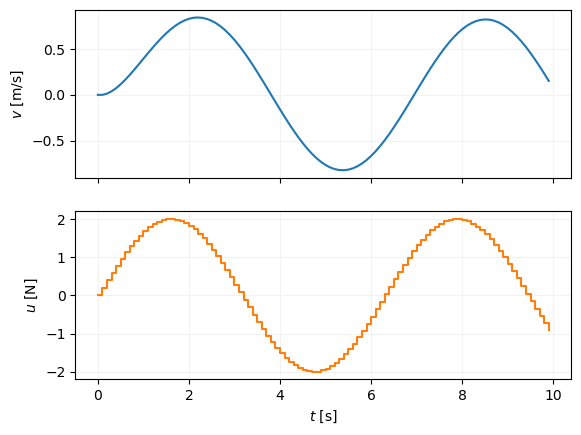

In [4]:
# So we can use LaTeX in our text
plt.rc("text", usetex=False)

# So we can use some additional math features in our text
plt.rc("text.latex", preamble=r"\usepackage{amsmath}")

# Some options for saving figures
plt.rc("savefig", format="pdf")
plt.rc("savefig", bbox="tight")
fig1 = plt.figure(1)
# Plot the speed
ax1a = plt.subplot(211)
plt.plot(t, v, "C0")
plt.grid(color="0.95")
plt.ylabel(r"$v$ [m/s]")
plt.setp(ax1a, xticklabels=[])
# Plot the input
ax1b = plt.subplot(212)
plt.step(t, u, "C1", where="post")
plt.grid(color="0.95")
plt.ylabel(r"$u$ [N]")
plt.xlabel(r"$t$ [s]")

# plt.savefig("sim-open-loop.pdf")
plt.show()

## Proportional (P) Control

Suppose we want a control system that automatically computes the inputs $u(t)$ to have the robot track a desired constant speed setting $v_d \text[m/s]$ just like the cruise control system.
Let $e(t) := v_d - v(t)$ be the error between the desired speed (set by the user) and the robot's actual speed. Thus, the control problem is to find $u(t)$ such that $e(t) \rightarrow 0 $ as $t \rightarrow \infty$ (making the error go zero)

Start by computing the error dynamics
$$\dot{e}(t)=0 - \dot{v}(t)=\frac{c_d}{m} v(t) - \frac{1}{m}u(t)=\frac{c_d}{m}(v_d - e(t)) - \frac{1}{m}u(t)$$

The most simple feedback control structure is _proportional (P)_ control. In this case, choose

$$u(t) = k_{\text p} e(t) + c_d v_d$$

where $ k_{\text p} \in \mathbb{R}$ is called the proportional gain and the term $c_d v_d$ is called a feed-forward term. Substituting this into the error dynamics above yields:

$$\dot{e}(t) = - \frac{1}{m} (c_d +  k_{\text p}) e(t)$$

Use Laplace transform; the solution to this ODE is 

$$e(t)  = e(0) e^{-\frac{1}{m} (c_d +  k_{\text p}) t}$$

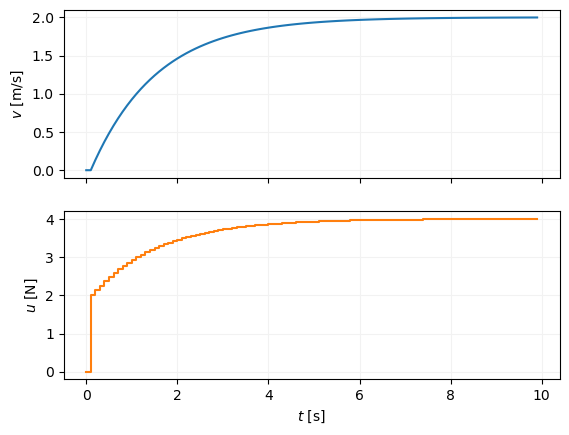

In [10]:
# pick a proportional gain

V_DESIRED = 2.0
K_P = -C_DRAG + 1.0

# Set the initial conditions
v[0] = 0.0
u[0] = 0.0

# Simulate the closed-loop response
for k in range(1, N):
    v[k] = robot_speed(v[k-1], u[k-1], T)
    u[k] = K_P * (V_DESIRED - v[k]) + C_DRAG * V_DESIRED

# Plot the simulation output
fig2 = plt.figure(2)
# Plot the speed
ax2a = plt.subplot(211)
plt.plot(t, v, "C0")
plt.grid(color="0.95")
plt.ylabel(r"$v$ [m/s]")
plt.setp(ax2a, xticklabels=[])
# Plot the input
ax2b = plt.subplot(212)
plt.step(t, u, "C1", where="post")
plt.grid(color="0.95")
plt.ylabel(r"$u$ [N]")
plt.xlabel(r"$t$ [s]")
# plt.savefig("sim-P-control.pdf")
plt.show()

## Proportional-Integral (PI) Control

**Integral Action**

Adds an extra term to controller design that tries to learn the feed-forward term and even the extra resistance due to gravity. Implement the _proportional-integral (PI)_ controller:

$$u(t) = k_{\text p} (u_d - v(t)) + k_I \int_0^t (v_d - v(\tau))d\tau$$

where $k_I \in \mathbb{R}$ is the integral gain. In discrete time, we implement this design as:

$$u_k = k_{\text p} (v_d - v_k) + k_I T \sum_{i=0}^{k} (v_d - v_i)$$



In [11]:
class PI_Controller:
    """Proportional-Integral (PI) controller class"""

    def __init__(self, k_P, k_I, u_max, T):
        self.k_P = k_P # proportional gain
        self.k_I = k_I # integral gain
        self.T = T # sample period
        self.e_integral = 0.0
        self.u_max = u_max # maximum control signal output magnitude

    def compute_PI(self, e):
        """
        e : error signal
        u : control signal (controller output)
        """
        # Compute the control signal output
        u = self.k_P * e + self.k_I * self.e_integral

        # Check for control signal saturation
        if u >= abs(self.u_max):
            # saturate the control signal
            u = np.sign(u) * self.u_max
        else:
            # only integrate if control signal is not saturated (anti-windup)
            self.e_integral += self.T * e

        return u

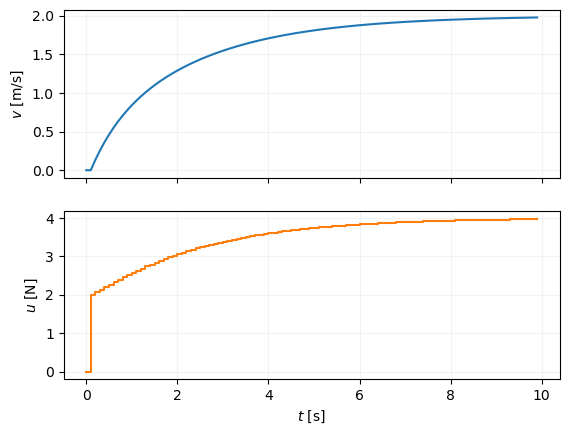

In [12]:
# simulation with a controller design that has no prior knowledge about the 
# exact nature of the drag coefficient

# pick a proportional gain
V_DESIRED = 2.0
K_P = 1.0
K_I = 1.0
U_MAX = 20.0

# Instantiate a controller class
controller = PI_Controller(K_P, K_I, U_MAX, T)

# Set the initial conditions
v[0] = 0.0
u[0] = 0.0

# simulate the closed-loop response
for k  in range(1, N):
    v[k] = robot_speed(v[k-1], u[k-1], T)
    u[k] = controller.compute_PI(V_DESIRED - v[k])

# Plot the simulation output
fig3 = plt.figure(3)
# Plot the speed
ax3a = plt.subplot(211)
plt.plot(t, v, "C0")
plt.grid(color="0.95")
plt.ylabel(r"$v$ [m/s]")
plt.setp(ax3a, xticklabels=[])
# Plot the input
ax3b = plt.subplot(212)
plt.step(t, u, "C1", where="post")
plt.grid(color="0.95")
plt.ylabel(r"$u$ [N]")
plt.xlabel(r"$t$ [s]")
# plt.savefig("sim-PI-control.pdf")
plt.show()

## Proportional-Derivative (PD) Control

Now want to solve a praking problem. In this case, we re-write the equations of motion for the robot in terms of its positions $x \in \mathbb{R}$, such that:

$$\dot{x}(t) = v(t)$$
$$\dot{v}(t) = - \frac{c_d}{m} v(t) + \frac{1}{m} u(t)$$

Rename variables : $x_1 := x & x_2 := v$

$$\dot{x_1}(t)=x_2(t)$$
$$\dot{x_2}(t) = - \frac{c_d}{m} x_2(t) + \frac{1}{m} u(t)$$

This is what we call state variable form or a state space model:
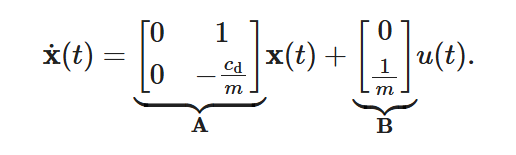

error term:
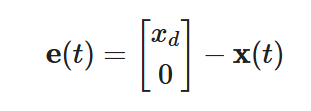

error dynamics:
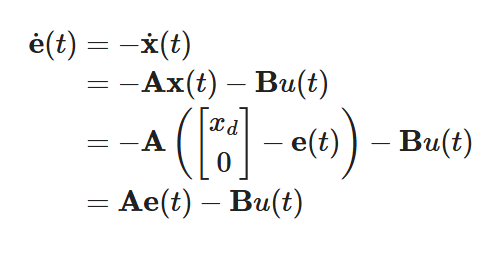

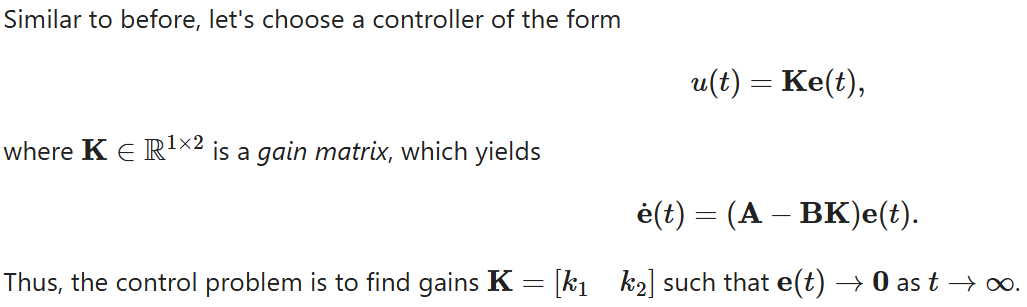
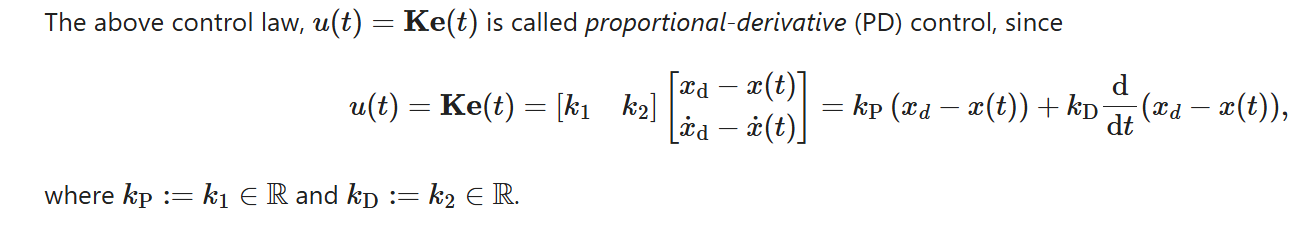

In [13]:
class PD_Controller:
    """Proportional-Derivative (PD) controller class"""
    def __init__(self, k_P, k_D, u_max, T):
        self.k_P = k_P # proportional gain
        self.k_D = k_D # derivative gain
        self.T = T # sample period
        self.e_last = 0.0
        self.derivative = 0.0
        self.u_max = u_max # max control signal output

    def compute_PD(self, e):
        """
        e : error signal
        u : control signal
        """

        # compute the (first-order) derivative of the error
        self.e_derivative = (e - self.e_last) / T

        # compute the control signal
        u = self.k_P * e + self.k_D * self.e_derivative

        # check for control signal saturation
        if u >= abs(self.u_max):
            # saturate the control signal
            u = np.sign(u) * self.u_max

        # save the latest error
        self.e_last = e

        return u

In [14]:
# arbitrarily choose the eigenvalue locations for the closed-loop matrix;
# k1 and k2 are chosen to give the desired transient behavior

A = np.array([[0, 1], [0, -C_DRAG / MASS]])
B = np.array([[0], [1.0 / MASS]])
C = np.array([[1.0, 0]])

# Use scipy.signal.con2discrete for conversion
# Zero-order hold (zoh)
# Goal: find a discrete-time version of the continuous-time linear model
from scipy.signal import cont2discrete

# Find a discrete-time model with the input applied using ZOH
dt_system = cont2discrete((A, B, C, np.array([[0.0]])), T, method="zoh")
F = dt_system[0]
G = dt_system[1]
H = dt_system[2]

# Create a function for the model
def robot_model(x, u):
    """Discrete-time model."""

    x_new = F @ x + G @ [u]
    return x_new

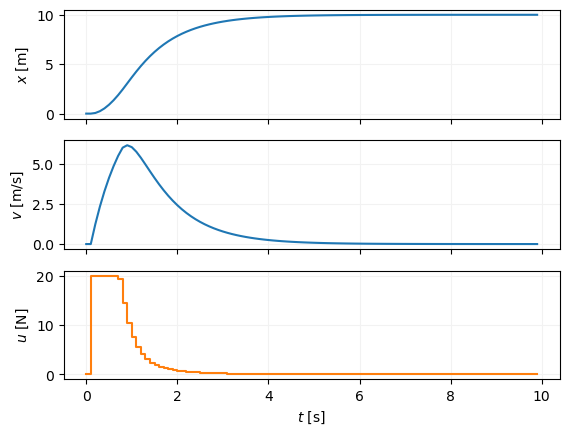

In [16]:
# Use scipy.signal.place_poles to find gains from chosen eigenvalues—also called poles.

from scipy.signal import place_poles

# Set the desired position [m]
X_DESIRED = 10.0

# Set the maximum input
U_MAX = 20.0

# compute some gains by picking eigenvalues in the left-half complex plane
EIG = np.array([-2.5, -1.25])
K = place_poles(A, B, EIG)
K_P = K.gain_matrix[0][0]
K_D = K.gain_matrix[0][1]

# create the controller object
controller = PD_Controller(K_P, K_D, U_MAX, T)

# Initialize some arrays and initial conditions
x = np.zeros((2, N))
u = np.zeros(N)

x[0, 0] = 0.0
x[1, 0] = 0.0
u[0] = 0.0

# simulate the closed-loop response
for k in range(1, N):
    # run the robot model for one time step
    x[:, k] = robot_model(x[:, k - 1], u[k - 1])
    # compute the control signal
    u[k] = controller.compute_PD(X_DESIRED - x[0, k])

# Plot the simulation output
fig4 = plt.figure(4)
# Plot the speed
ax4a = plt.subplot(311)
plt.plot(t, x[0, :], "C0")
plt.grid(color="0.95")
plt.ylabel(r"$x$ [m]")
plt.setp(ax4a, xticklabels=[])
ax4b = plt.subplot(312)
plt.plot(t, x[1, :], "C0")
plt.grid(color="0.95")
plt.ylabel(r"$v$ [m/s]")
plt.setp(ax4b, xticklabels=[])
# Plot the input
ax4c = plt.subplot(313)
plt.step(t, u, "C1", where="post")
plt.grid(color="0.95")
plt.ylabel(r"$u$ [N]")
plt.xlabel(r"$t$ [s]")
# plt.savefig("sim-PD-control.pdf")
plt.show()

## Proportional-Integral-Derivative (PID) Control


In [17]:
# class for PID controller design

class PID_Controller:
    """Proportional-Integral-Derivative (PID) controller class"""

    def __init__(self, k_P, k_I, k_D, u_max, T):
        self.k_P = k_P # proportional gain
        self.k_I = k_I # integral gain
        self.k_D = k_D # derivative gain
        self.T = T # sample period
        self.e_last = 0.0
        self.y_last = 0.0
        self.e_integral = 0.0
        self.e_derivative = 0.0
        self.u_max = u_max

    def compute_PID(self, e):
        # compute the first-order derivative of the error
        self.e_derivative = (e - self.e_last) / T

        # compute the control signal
        u = self.k_P * e + self.k_I * self.e_integral + self.k_D * self.e_derivative

        # check for control signal saturation
        if u >= abs(self.u_max):
            # saturate the control signal
            u = np.sign(u) * self.u_max
        else:
            # only integrate if control signal is not saturated
            self.e_integral += self.T * e

        # save the latest error
        self.e_last = e

        return u

Test the PID design. 

Consider the case where the robot is now going up or down a hill with slope $\theta \in (-\frac{\pi}{2}, \frac{\pi}{2})$, we have

$$u(t) - c_d v(t) - mg \text {sin}\theta = m \dot{v} (t)$$

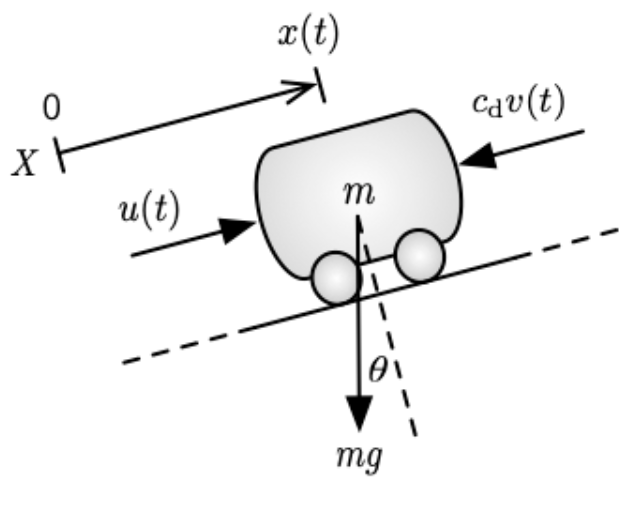

we could again try to feed-forward the gravity term $mg sin\theta$, but it is unlikely, in practice, that we will ever precissely know the mass, gravity, and angle of the slope

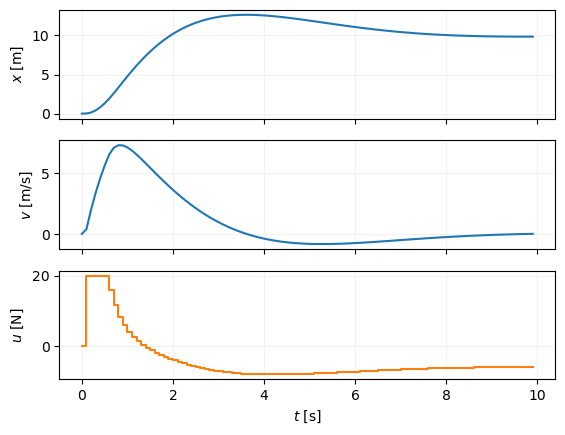

In [19]:
from scipy.signal import place_poles

# set the desired position [m]
X_DESIRED = 10.0

# set the maximum input [N]
U_MAX = 20.0

# compute some gains by picking eigenvalues in the left-half complex plane
EIG  = np.array([-2.5, -1.25])
K = place_poles(A, B, EIG)
K_P = K.gain_matrix[0][0]
K_D = K.gain_matrix[0][1]
K_I = 2.0

# create the controller object
controller = PID_Controller(K_P, K_I, K_D, U_MAX, T)

# Initialize some arrays and initial conditions
x = np.zeros((2, N))
u = np.zeros(N)
x[0, 0] = 0.0
x[1, 0] = 0.0
u[0] = 0.0

# pick an unknown slope [deg]
SLOPE = 30

# simulate the closed-loop response
for k in range(1, N):
    # run the robot model for one time step with unknown slope
    x[:, k] = robot_model(
        x[:, k - 1], u[k - 1] - MASS * 9.91 * np.sin(180 / np.pi * SLOPE)
    )
    # Compute the control signal
    u[k] = controller.compute_PID(X_DESIRED - x[0, k])

# Plot the simulation output
fig5 = plt.figure(5)
# Plot the speed
ax5a = plt.subplot(311)
plt.plot(t, x[0, :], "C0")
plt.grid(color="0.95")
plt.ylabel(r"$x$ [m]")
plt.setp(ax5a, xticklabels=[])
ax5b = plt.subplot(312)
plt.plot(t, x[1, :], "C0")
plt.grid(color="0.95")
plt.ylabel(r"$v$ [m/s]")
plt.setp(ax5b, xticklabels=[])
# Plot the input
ax5c = plt.subplot(313)
plt.step(t, u, "C1", where="post")
plt.grid(color="0.95")
plt.ylabel(r"$u$ [N]")
plt.xlabel(r"$t$ [s]")
# plt.savefig("sim-PID-control.pdf")
plt.show()

## Summary of key concepts

1. Integral action can help a controller to account for unknown disturbances and un-modelled effects. Without integral action, we may end up with steady-state errors.
2. Derivative action, if necessary (i.e., we have at least a second-order system) is often needed to manipulate the transient response of the closed-loop system to achieve desired performance. 

# PID Tuning

## Controller Design Objectives

Choosing the structure of a controller and its parameters (i.e., tuning controller gains) depends on the performance requirements. In many applications (e.g., in robotics), we usually have two design objectives

1. We would like that the tracking error for step inputs to the reference signal to be zero. Moreover, we would like to track comparatively low bandwidth signals up to a specified frequency $\omega_d > 0$ with a small tracking error as possible. Practically speaking, the physics of the system itself will likely determine how hgih you can make this frequency.
2. We would like the closed-loop response to have very high damping (i.e., smooth behaviorr with (minimal oscillations). This usually makes sense for most mechanical systems (e.g., motors, robots)

Final value theorem that the sensitivity function:
$$S(s):= \frac{1}{1 + P_0 (s)C(s)}$$
where $C(s)$ is the controller design, determines the steady-state tracking error $e(\infty)$
$$e(\infty) = \lim_{s\rightarrow 0} s S(s) \frac{1}{s} = S(0) = 0$$
for the steady-state error corresponding to a step input in the reference signal. Thus, out design objectives can be satisfied if the sensitivity function is first order (no overshoot) and of the form:
$$S(s) = \frac {s} {s + \omega_{\text CL}}$$
where $\omega_{\text CL}$ is approximately the closed-loop bandwidth of the controlled system.

To track reference signals up to a bandwidth of $\omega_{\text d} > 0$ we want that

$$ \left| \frac{j \omega_{\text d}} {j \omega_{\text d} + \omega_{\text CL}} \right| \leq \delta$$

where $j := \sqrt {-1}$ and $\delta < 1$ is sufficiently small. Rearranging, we find that:
$$\omega_{\text CL} \geq \frac{\sqrt {1 - \delta^2}} {\delta} \omega_{\text d}$$

This shows that the tracking error for signals up to frequency $\omega_{\text d}$ can be improved by increasing the bandwidth of the closed-loop system (i.e., increasing the loop gain)

## Controller Design & Example

Assumption: plant itself is stable. In this case, the set of all stabilizing controllers is given by:
$$C(Q(s)) = \frac{Q(s)}{1 - P_0(s)Q(s)}$$
where $Q(s)$ is any stable, proper, and real rational transfer function. By the definition of $S(s)$
$$S(s) = 1 - P_0(s)Q(s)$$
such that
$$Q(s) = \frac{1 - S(s)}{P_0(s)}$$

### Controller design for First-Order systems

Consider a common first-order plant with transfer function
$$P_0(s) = \frac{a}{s+b}$$

The steady-state value for this plant is $P_0(0)=a/b$.

According to design requirements, we would like a sensitivity function of the form:
$$Q(s) = \left( \frac{s+b}{a} \right) \left( 1 - \frac{s}{s+ \omega_{\text CL}} \right) =\frac{\omega_{\text CL}}{a} \left( \frac{s+b}{s + \omega_{\text CL}}\right) $$
Substitute for $C(s)$

$$C(s) = \frac{\omega_{\text CL}}{a} \left(1 +  \frac{b}{s} \right) $$

which is merely a PI controller of the form
$$C(s) = k_P + \frac {k_I}{s}$$

with proportional and integral controller gains:
$$k_P = \frac{1}{a} \omega_{\text CL}, k_I = \frac{b}{a} \omega_{\text CL}$$

Thus, to tune this controller we now have only to adjust the closed-loop bandwidth $\omega_{\text CL} > 0$. Ideally we would like to make this as high as possible, although we will of course be limited by the actual dynamics of the system to be controlled.

### Numerical Example: Vehicle Cruise Control

Given system transfer fucntion (first order)

$$P(s) = \frac {V(s)}{U(s)} = \frac {1/m} {s + c_d/m}$$

Simulate the vehicle's response to a step input in u(t)


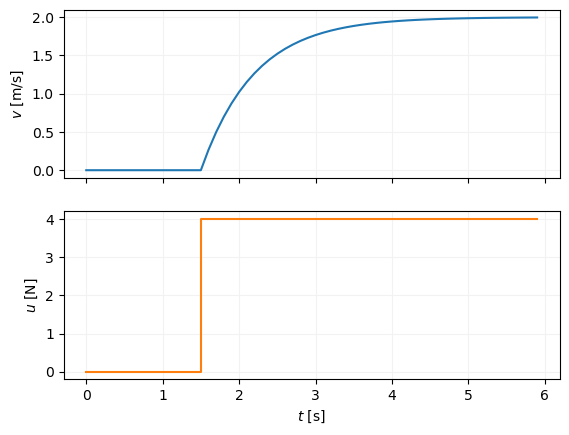

In [20]:
import numpy as np
import matplotlib.pyplot as plt

SIM_TIME = 6.0
T = 0.1
MASS = 1.5
C_DRAG = 2.0

t = np.arange(0, SIM_TIME, T)
N = np.size(t)

def vehicle_speed(v, u, T):
    """Discrete-time 1D vehicle speed model."""

    v_new = v + T * 1 / MASS * (u - C_DRAG * v)
    return v_new

U_STEP = 4.0 # force by actuactor

v = np.zeros(N)
u = np.zeros(N)
v[0] = 0.0
u[0] = 0.0

# For each time step, simulate vehicle motion
for k in range(1, N):
    # Run the vehicle speed model for one time step
    v[k] = vehicle_speed(v[k - 1], u[k - 1], T)
    # Change (step) the input part way through the simulation
    if k < N / 4:
        u[k] = 0.0
    else:
        u[k] = U_STEP

# plot simulation results
plt.rc("text", usetex=False)

plt.rc("text.latex", preamble=r"\usepackage{amsmath}")

plt.rc("savefig", format="pdf")
plt.rc("savefig", bbox="tight")
fig1 = plt.figure(1)
ax1a = plt.subplot(211)
plt.plot(t, v, "C0")
plt.grid(color="0.95")
plt.ylabel(r"$v$ [m/s]")
plt.setp(ax1a, xticklabels=[])
ax1b = plt.subplot(212)
plt.step(t, u, "C1", where="post")
plt.grid(color="0.95")
plt.ylabel(r"$u$ [N]")
plt.xlabel(r"$t$ [s]")
# plt.savefig("sim-step-input.pdf")
plt.show()

### Closed-Loop Control

Apply the controller design for 1st order system. In this example, $a:= 1/m$ and $b := c_d/m$, which we use to find the controller gains as k_P and k_I. We must first choose the desired close-loop bandwidth $\omega_{\text CL} \text[rad/s]$ as OMEGA_CL

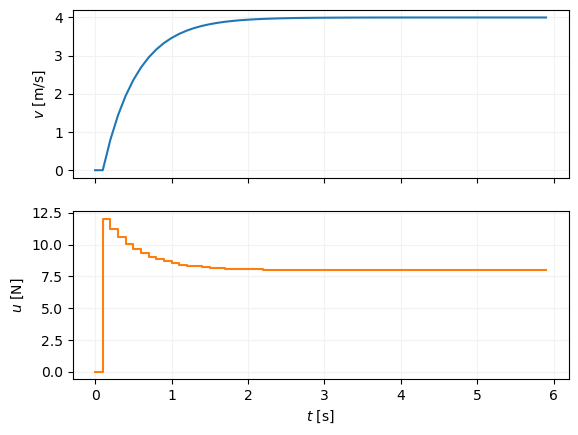

In [22]:
OMEGA_CL = 2.0

# compute the controller gains using the formula
a = 1 / MASS
b = C_DRAG / MASS
k_P = (1 / a) * OMEGA_CL
k_I = (b / a ) * OMEGA_CL

# set a desired speed setting for the cruise control
V_DESIRED = 4.0

# Suppose the vehicle has a maximum available propulsion force U_MAX
U_MAX = 20.0

# Simulate the closed-loop control system
# initialize variable arrays and set the initial conditions
v = np.zeros(N)
u = np.zeros(N)
v[0] = 0.0
u[0] = 0.0

# PI controller
class PI_Controller:
    """Proportional-Integral (PI) controller class."""

    def __init__(self, k_P, k_I, u_max, T):

        self.k_P = k_P
        self.k_I = k_I
        self.T = T
        self.e_integral = 0.0
        self.u_max = u_max

    def compute_PI(self, e):
        """Compute the controller output."""

        # Compute the control signal output
        u = self.k_P * e + self.k_I * self.e_integral

        # Check for control signal saturation
        if u >= abs(self.u_max):
            # Saturate the control signal
            u = np.sign(u) * self.u_max
        else:
            # Only integrate if control signal is not saturated (anti-windup)
            self.e_integral += self.T * e

        return u

controller = PI_Controller(k_P, k_I, U_MAX, T)

for k in range(1, N):
    v[k] = vehicle_speed(v[k - 1], u[k - 1], T)
    u[k] = controller.compute_PI(V_DESIRED - v[k])

# plot results
fig2 = plt.figure(2)
ax2a = plt.subplot(211)
plt.plot(t, v, "C0")
plt.grid(color="0.95")
plt.ylabel(r"$v$ [m/s]")
plt.setp(ax2a, xticklabels=[])
ax2b = plt.subplot(212)
plt.step(t, u, "C1", where="post")
plt.grid(color="0.95")
plt.ylabel(r"$u$ [N]")
plt.xlabel(r"$t$ [s]")
plt.show()

### Controller Design for Second-Order Systems

Now we consider a common second-order plant with TF:
$$ P_0  = \frac {a} {s^2 + bs + c} $$

Note that the steady-state gain for this plant is $P_0(0) = a / c$.

Try a slightly different sensitivity function (because Q(s) is not proper in the 2nd order case):
$$\tilde{S} (s) = \frac {s(s + 2 \omega_{\text CL})} {(s + \omega_{\text CL})^2}$$

yields

$$Q(s) = \frac{\omega_{\text CL}^2}{(s+\omega_{\text CL})^2} \left( \frac {s^2 + bs + c} {a} \right)$$

which is a first-order low-pass filter together a PID controller of the form

$$C(s) = \frac{\omega_c}{s+\omega_c} \left( k_P + \frac {k_I}{s} + k_Ds \right )$$

where the filter cut-off $\omega_c$ frequency and controller gains are:

$$\omega_c = 2 \omega_{\text CL}, k_P = \frac {b\omega_{\text CL}} {2a}, k_I = \frac {c\omega_{\text CL}} {2a}, k_D = \frac {\omega_{\text CL}} {2a}$$

### Numerical Example: DC Motor Speed Control

Consider a DC motor where the input is a voltage $v [V]$ and the output is the rotational speed of the motor $\dot{\theta} [rad/s]$. Let $J [kg/m^2]$ be the motor's moment of inertia, $b_f [N m s]$ be the motor's iscous fricition constant, $K_e [V/rad/s]$ be the electromotive force constant, $K_t [N m/A]$ be the motor torque constant, $R [\Omega]$ be the electric resistance, and $L [H]$ ne the electric inductance. 

Transfer function:
$$\frac{s\Theta(s)}{V(s)} = \frac{\frac{K_t}{JL}}{s^2 + \frac{b_fL + RJ}{JL}s + \frac{b_fR + K_eK_t}{JL}}$$

which is a second order system

In [23]:
SIM_TIME = 6.0
T = 0.1
t = np.arange(0, SIM_TIME, T)
N = np.size(t)

# motor parameters
J = 0.01
B_FRICTION = 0.01
K_E = 0.01
K_T = 0.01
R = 1
L = 0.5


Write a function to model the motor's speed as a function of voltage input $v$. Because the simulation happens in the time domain, we use a state-space realization of motor model for simulatio purposes. Let $x_1 := \dot{\theta}$ and $x_2 := i$ be the states for 2nd order system:

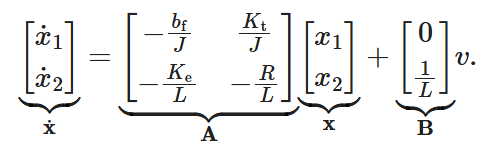

We want output $\dot{\theta}=Cx=x_1$, such that C = [1 0]

In [24]:
A = np.array([[-B_FRICTION / J, K_T / J], [-K_E / L, -R / L]])
B = np.array([[0], [1.0 / L]])
C = np.array([[1.0, 0]])

To simulate this system, find a discrete-time equivalent using sample period $T > 0$. We use the notation $x_k := x(kT)$, where $k = 0, 1, 2, ...$ is the time step. If the voltage input is held constant between time steps (i.e., zero-order hold), then a discrete-time model for the system is given by:
$$x_{k+1} = F x_k + G v_k $$

where
$$F = e^{AT}$$
$$G = F \int_0^T e^{-A \tau} d \tau{B}$$

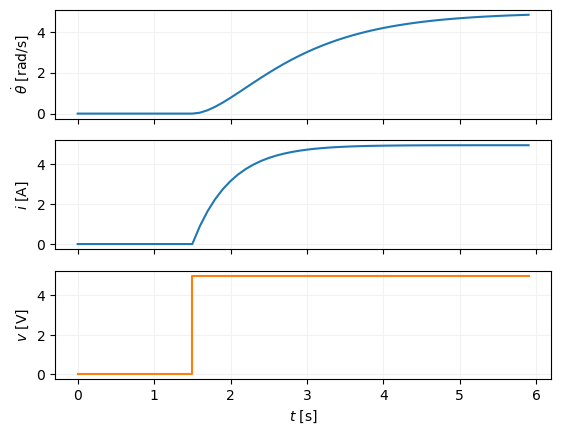

In [26]:
from scipy.signal import cont2discrete

dt_system = cont2discrete((A, B, C, np.array([0.0])), T, method="zoh")
F = dt_system[0]
G = dt_system[1]
H = dt_system[2]

# function to implement DC motor's state-space model
def motor_speed(x, v):
    """Discrete-time DC motor speed model"""

    x_new = F @ x + G @ [v]
    return x_new

# sim step input response to check the model behavior
V_STEP = 5

# initialize some arrays and initial conditions
x = np.zeros((2, N))
v = np.zeros(N)
x[0, 0] = 0.0
x[1, 0] = 0.0
v[0] = 0.0

for k in range(1, N):
    # run the motor speed model for one time step
    x[:, k] = motor_speed(x[:, k - 1], v[k - 1])
    # change the input part way through the simulation
    if k < N / 4:
        v[k] = 0.0
    else:
        v[k] = V_STEP

# plot the statte and input voltage
# Note that the 2nd order response is the motor speed \dot{theta}
fig3 = plt.figure(3)
ax3a = plt.subplot(311)
plt.plot(t, x[0, :], "C0")
plt.grid(color="0.95")
plt.ylabel(r"$\dot{\theta}$ [rad/s]")
plt.setp(ax3a, xticklabels=[])
ax3b = plt.subplot(312)
plt.plot(t, x[1, :], "C0")
plt.grid(color="0.95")
plt.ylabel(r"$i$ [A]")
plt.setp(ax3b, xticklabels=[])
ax3c = plt.subplot(313)
plt.step(t, v, "C1", where="post")
plt.grid(color="0.95")
plt.ylabel(r"$v$ [V]")
plt.xlabel(r"$t$ [s]")
plt.show()

### closed-loop control

Apply the controller design methodology for 2nd order systems. Using the derived motor model (in the Laplace domain), we have

$$a = \frac{K_t}{JL}$$
$$b = \frac{b_fL + RJ}{JL}$$
$$c = \frac{b_fR + K_eK_t}{JL}$$

In [36]:
# set the desired closed-loop bandwidth [rad/s]
OMEGA_CL = 3.0

# compute the filter cutoff frequency [rad/s]
OMEGA_C = 2.0 * OMEGA_CL

# compute the model parameters
a = K_T / (J * L)
b = (B_FRICTION * L + R * J) / (J * L)
c = (B_FRICTION * R + K_E * K_T) / (J * L)

# compute the corresponding controller gains
k_P = b * OMEGA_CL / (2.0 * a)
k_I = c * OMEGA_CL / (2.0 * a)
k_D = OMEGA_CL / (2.0 * a)

In [37]:
# Class for PID controller with post-filter

class PID_Controller:
    def __init__(self, k_P, k_I, k_D, u_max, T):
        self.k_P = k_P
        self.k_I = k_I
        self.k_D = k_D
        self.T = T
        self.e_last = 0.0
        self.y_last = 0.0
        self.e_integral = 0.0
        self.e_derivative = 0.0
        self.u_max = u_max

    def compute_PID(self, e):
        # compute the 1st order derivative of the error
        self.e_derivative = (e - self.e_last) / T
        # compute the control signal
        u = self.k_P * e + self.k_I * self.e_integral + self.k_D * self.e_derivative

        # check for control signal saturation
        if u >= abs(self.u_max):
            # saturate the control signal
            u = np.sign(u) * self.u_max
        else:
            # only integrate if control signal is not saturated
            self.e_integral += self.T * e

        # save the latest error
        self.e_last = e

        return u

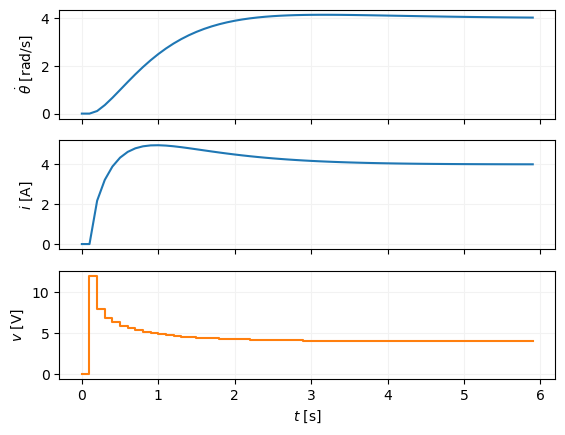

In [38]:
# Run simulation with PID control

SPEED_D = 4.0
V_MAX = 12.0 

# Create the controller object
controller = PID_Controller(k_P, k_I, k_D, V_MAX, T)

# Initialize some arrays and initial conditions
x = np.zeros((2, N))
v = np.zeros(N)
x[0, 0] = 0.0
x[1, 0] = 0.0
v[0] = 0.0

for k in range(1, N):
    # Run the motor speed model for one time step
    x[:, k] = motor_speed(x[:, k - 1], v[k - 1])
    # Compute the control signal
    v[k] = controller.compute_PID(SPEED_D - x[0, k])

# plot
fig4 = plt.figure(3)
ax4a = plt.subplot(311)
plt.plot(t, x[0, :], "C0")
plt.grid(color="0.95")
plt.ylabel(r"$\dot{\theta}$ [rad/s]")
plt.setp(ax4a, xticklabels=[])
ax4b = plt.subplot(312)
plt.plot(t, x[1, :], "C0")
plt.grid(color="0.95")
plt.ylabel(r"$i$ [A]")
plt.setp(ax4b, xticklabels=[])
ax4c = plt.subplot(313)
plt.step(t, v, "C1", where="post")
plt.grid(color="0.95")
plt.ylabel(r"$v$ [V]")
plt.xlabel(r"$t$ [s]")
plt.show()
